# EE219 Project 3

### Team members:
* **Yin Fei** 404284074

* **Yichen Wu** 504294181

* **Siyuan Chen** 405024391

* **Ruchen Zhen** 205036408

### Required Packages:
python 3.6  
numpy v1.14.0  
scikit-learn v0.19.1  
scipy v1.0.0  
matplotlib v2.1.2  
pandas v0.22.0   
surprise v0.1  
scikit-surprise v1.0.5


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import logging
import pickle
import os
from logging.config import fileConfig

# create logger
fileConfig('logging_config.ini')
logger = logging.getLogger()
logger.setLevel("WARNING")
# logger.setLevel("INFO")

GET_DATA_FROM_FILES = True

# load data
r_data = pd.read_csv('data/ratings.csv', header=0, usecols=[0, 1, 2])
print(r_data.head())
R = r_data.pivot_table(index='userId', columns='movieId', 
                       values='rating').values
print("(number of users, number of rated movies): ", R.shape)


   userId  movieId  rating
0       1       31     2.5
1       1     1029     3.0
2       1     1061     3.0
3       1     1129     2.0
4       1     1172     4.0
(number of users, number of rated movies):  (671, 9066)


#### Question 1

In [43]:
# Question 1
user_count = R.shape[0]
movie_count = R.shape[1]
max_rating_count = user_count*movie_count
rating_count = len(r_data.rating.tolist())
sparsity = rating_count*1.0/max_rating_count
print("Matrix sparsity = %0.4f" % sparsity)

Matrix sparsity = 0.0164


#### Question 2

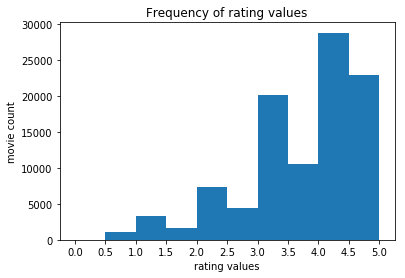

In [44]:
# Question 2
plt.figure()
ax = plt.subplot(111)
ratings = r_data.rating.tolist()
xrange = np.arange(0, 5.5, 0.5)
ax.hist(ratings, bins=xrange)
ax.set_xticks(xrange)
ax.set_title("Frequency of rating values")
ax.set_xlabel("rating values")
ax.set_ylabel("movie count")
plt.show()

#### Question 3

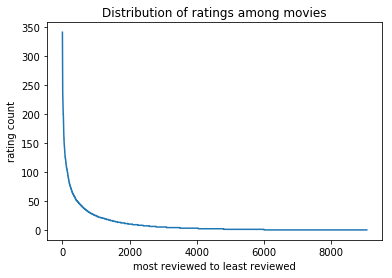

In [45]:
# Question 3
plt.figure()
movie_rating_count = np.count_nonzero(~np.isnan(R), axis=0)
sorted_mrc = sorted(movie_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(movie_rating_count)), sorted_mrc, '-')
ax.set_title("Distribution of ratings among movies")
ax.set_xlabel("most reviewed to least reviewed")
ax.set_ylabel("rating count")
plt.show()

#### Question 4

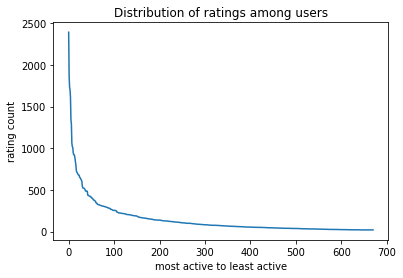

In [46]:
# Question 4
plt.figure()
user_rating_count = np.count_nonzero(~np.isnan(R), axis=1)
sorted_urc = sorted(user_rating_count, reverse=True)
ax = plt.subplot(111)
ax.plot(range(len(user_rating_count)), sorted_urc, '-')
ax.set_title("Distribution of ratings among users")
ax.set_xlabel("most active to least active")
ax.set_ylabel("rating count")
plt.show()

#### Question 5
ToDo: Explain the salient features of the distribution found in question 3 and their implications for the recommendation process.

#### Question 6

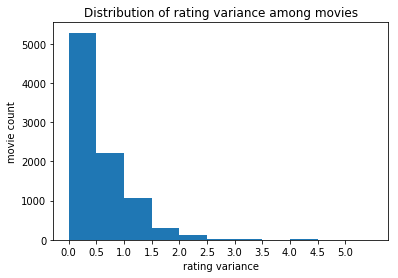

In [47]:
# Question 6
plt.figure()
ax = plt.subplot(111)
movie_var = np.nanvar(R, axis=0)
var_range = np.arange(min(movie_var), max(movie_var)+0.5, 0.5)
ax.hist(movie_var, bins=var_range)
ax.set_xticks(xrange)
ax.set_title("Distribution of rating variance among movies")
ax.set_xlabel("rating variance")
ax.set_ylabel("movie count")
plt.show()

#### Question 7

$I_u$ : Set of item indices for which ratings have been specifed by user $u$  
$I_v$ : Set of item indices for which ratings have been specifed by user $v$  
$\mu_u$ : Mean rating for user $u$ computed using her specifed ratings  
$r_{uk}$ : Rating of user $u$ for item $k$  

$$\mu_u = \frac{\Sigma_{i\in I_{u}} r_{ui}}{\mid I_u \mid}$$

#### Question 8

$I_{u} \cap I_{v}$ represents the indices of movies that are rated by both user $u$ and user $v$. It's possible that this intersection be the empty set ($\emptyset$), given the sparsity of the matrix. It happens when user $u$ has not rated any movie that user $v$ has.

#### Question 9

By doing mean centering, we are able to decrease the multicollinearity between a single users' rating and its corresponding effects. For instance, if we encounter multiple users who rate all items highly, our predicted rating will be greatly affect by this. However, with mean centering, this problem is resovled.

#### Question 10

In [48]:
import surprise
from surprise import Dataset
from surprise.model_selection import cross_validate
data = Dataset.load_builtin('ml-100k')

k_lst = range(2,101,2)

sim_options = {'name': 'pearson'}
rmse_lst=[]
mae_lst=[]

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_lst.pkl")\
                    and os.path.isfile("./mae_lst.pkl"):
    logging.info("Loading rmse_lst and mae_lst.")
    rmse_lst = pickle.load(open("./rmse_lst.pkl", "rb"))
    mae_lst = pickle.load(open("./mae_lst.pkl", "rb"))
else:
    for k in k_lst:
        algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=k, sim_options=sim_options)
        result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10)
        rmse_lst.append(np.mean(result['test_rmse']))
        mae_lst.append(np.mean(result['test_mae']))
    
    pickle.dump(rmse_lst, open("./rmse_lst.pkl", "wb"))    
    pickle.dump(mae_lst, open("./mae_lst.pkl", "wb"))

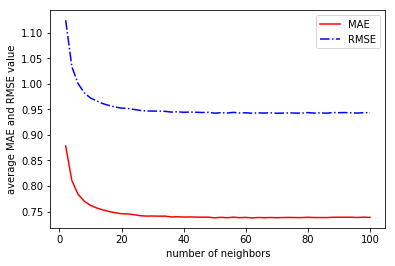

In [49]:
l1, = plt.plot(k_lst, mae_lst, 'r-', label='MAE')
l2, = plt.plot(k_lst, rmse_lst, 'b-.', label='RMSE')
plt.xlabel('number of neighbors')
plt.ylabel('average MAE and RMSE value')
plt.legend(handles=[l1, l2])
plt.show()

#### Question 11

The minimum $k$ is about __12__. MAE converges to __0.74__ and RMSE converges to __0.94__.

#### Question 12,13,14

In [50]:
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import KFold

In [51]:
def trim_popular(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter <= 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            lastm = m
        
        counter += 1
        trimmed.append((u, m, r))

    if counter <= 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [52]:
def trim_unpopular(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter > 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            lastm = m
        
        counter += 1
        trimmed.append((u, m, r))

    if counter > 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [53]:
def trim_highvar(testset):
    trimmed = []
    mat = np.array(testset, dtype=[('u', int), ('m', int), ('r', float)])
    mat.sort(order='m')
    counter = 0
    temp_r = []
    lastm = mat[0][1]
    for u, m, r in mat:
        if m != lastm:
            if counter < 5 or np.var(temp_r) < 2:
                for i in range(counter):
                    trimmed.pop(-1)

            counter = 0
            temp_r = []
            lastm = m
        
        counter += 1
        temp_r.append(r)
        trimmed.append((u, m, r))

    if counter < 5 or np.var(temp_r) < 2:
        for i in range(counter):
            trimmed.pop(-1)

    return trimmed

In [54]:
kf = KFold(n_splits=10)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(r_data[['userId', 'movieId', 'rating']], reader)

rmse_pop = []
rmse_unpop = []
rmse_highvar = []

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_pop.pkl")\
                    and os.path.isfile("./rmse_unpop.pkl")\
                    and os.path.isfile("./rmse_highvar.pkl"):
    logging.info("Loading rmse_pop, rmse_unpop and rmse_highvar.")
    rmse_pop = pickle.load(open("./rmse_pop.pkl", "rb"))
    rmse_unpop = pickle.load(open("./rmse_unpop.pkl", "rb"))
    rmse_highvar = pickle.load(open("./rmse_highvar.pkl", "rb"))
else:
    for k in k_lst:
        rmse_temp_pop = []
        rmse_temp_unpop = []
        rmse_temp_highvar = []
        algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=k, sim_options=sim_options)
        for trainset,testset in kf.split(data):
            algo.fit(trainset)
            predictions_pop = algo.test(trim_popular(testset))
            predictions_unpop = algo.test(trim_unpopular(testset))
            predictions_highvar = algo.test(trim_highvar(testset))
            rmse_temp_pop.append(accuracy.rmse(predictions_pop))
            rmse_temp_unpop.append(accuracy.rmse(predictions_unpop))
            rmse_temp_highvar.append(accuracy.rmse(predictions_highvar))
        rmse_pop.append(np.mean(rmse_temp_pop))
        rmse_unpop.append(np.mean(rmse_temp_unpop))
        rmse_highvar.append(np.mean(rmse_temp_highvar))

    pickle.dump(rmse_pop, open("./rmse_pop.pkl", "wb"))    
    pickle.dump(rmse_unpop, open("./rmse_unpop.pkl", "wb"))
    pickle.dump(rmse_highvar, open("./rmse_highvar.pkl", "wb"))

print(rmse_pop[:5])

[1.0474940413149139, 0.95481980124888055, 0.92194934099151138, 0.90665093687839526, 0.89817706028640032]


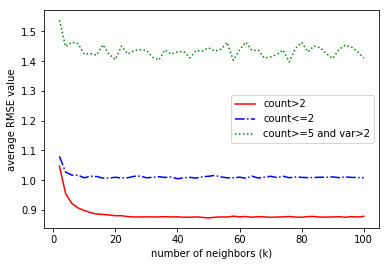

In [55]:
l1, = plt.plot(k_lst, rmse_pop, 'r-', label='count>2')
l2, = plt.plot(k_lst, rmse_unpop, 'b-.', label='count<=2')
l3, = plt.plot(k_lst, rmse_highvar, 'g:', label='count>=5 and var>2')
plt.xlabel('number of neighbors (k)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l1, l2, l3])
plt.show()

#### Question 15

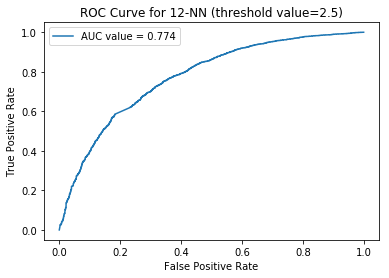

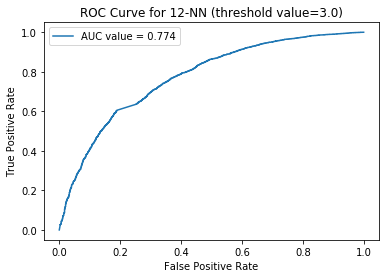

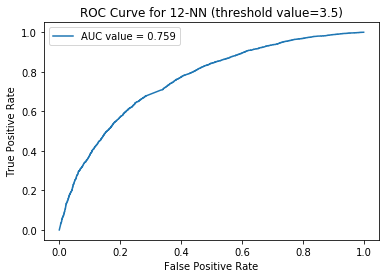

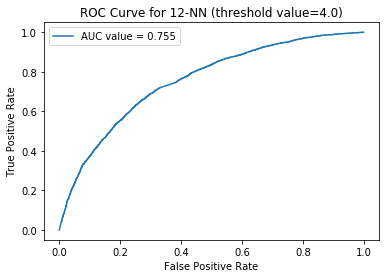

In [56]:
from sklearn import metrics
from surprise.model_selection import train_test_split
mink=12
thresholdlist = [2.5, 3, 3.5, 4]

pred = None
if GET_DATA_FROM_FILES and os.path.isfile("./pred_q15.pkl"):
    logging.info("Loading pred_q15.")
    pred = pickle.load(open("./pred_q15.pkl", "rb"))
else:
    algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=mink, sim_options=sim_options)
    trainset, testset = train_test_split(data, test_size=.1)
    algo.fit(trainset)
    pred = algo.test(testset)
    pickle.dump(pred, open("./pred_q15.pkl", "wb"))
        
for ths in thresholdlist:
    y_true=[]
    y_pred=[]
    for _,_,r_real,r_pred,_ in pred:
        if r_real >= ths:
            y_true.append(1)
        else:
            y_true.append(0)
        y_pred.append(r_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, label='AUC value = %0.3f' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for %d-NN (threshold value=%.1f)' % (mink, ths))
    plt.legend()
    plt.show()

#### Question 17

In [57]:
from surprise import NMF
k_nnmf = range(2,51,2)

rmse_nnmf=[]
mae_nnmf=[]

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_nnmf.pkl")\
                    and os.path.isfile("./mae_nnmf.pkl"):
    logging.info("Loading rmse_nnmf and mae_nnmf.")
    rmse_nnmf = pickle.load(open("./rmse_nnmf.pkl", "rb"))
    mae_nnmf = pickle.load(open("./mae_nnmf.pkl", "rb"))
else:
    for k in k_nnmf:
        algo = NMF(n_factors=k)
        result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10)
        rmse_nnmf.append(np.mean(result['test_rmse']))
        mae_nnmf.append(np.mean(result['test_mae']))
    
    pickle.dump(rmse_nnmf, open("./rmse_nnmf.pkl", "wb"))    
    pickle.dump(mae_nnmf, open("./mae_nnmf.pkl", "wb"))

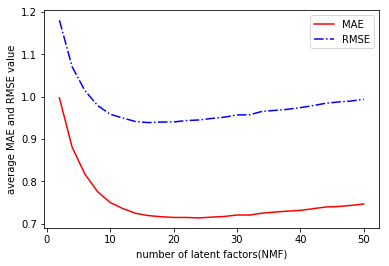

In [58]:
l1, = plt.plot(k_nnmf, mae_nnmf, 'r-', label='MAE')
l2, = plt.plot(k_nnmf, rmse_nnmf, 'b-.', label='RMSE')
plt.xlabel('number of latent factors(NMF)')
plt.ylabel('average MAE and RMSE value')
plt.legend(handles=[l1, l2])
plt.show()

#### Question 18

In [59]:
print('the value of k that gives the minimum average RMSE')
print(k_nnmf[np.argsort(rmse_nnmf)[0]])
print('minimum average RMSE:')
print(np.sort(rmse_nnmf)[0])

the value of k that gives the minimum average RMSE
16
minimum average RMSE:
0.93883589244


In [60]:
print ('the value of k that gives the minimum average MAE :')
print (k_nnmf[np.argsort(mae_nnmf)[0]])
print ('minimum average MAE:')
print (np.sort(mae_nnmf)[0])

the value of k that gives the minimum average MAE :
24
minimum average MAE:
0.713795966474


#### Question 19,20,21

In [61]:
kf = KFold(n_splits=10)

rmse_pop_nnmf = []
rmse_unpop_nnmf = []
rmse_highvar_nnmf = []

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_pop_nnmf.pkl")\
                    and os.path.isfile("./rmse_unpop_nnmf.pkl")\
                    and os.path.isfile("./rmse_highvar_nnmf.pkl"):
    logging.info("Loading rmse_pop_nnmf, rmse_unpop_nnmf and rmse_highvar_nnmf.")
    rmse_pop_nnmf = pickle.load(open("./rmse_pop_nnmf.pkl", "rb"))
    rmse_unpop_nnmf = pickle.load(open("./rmse_unpop_nnmf.pkl", "rb"))
    rmse_highvar_nnmf = pickle.load(open("./rmse_highvar_nnmf.pkl", "rb"))
else:
    for k in k_nnmf:
        rmse_temp_pop_nnmf = []
        rmse_temp_unpop_nnmf = []
        rmse_temp_highvar_nnmf = []
        algo = NMF(n_factors=k)
        for trainset,testset in kf.split(data):
            algo.fit(trainset)
            predictions_pop_nnmf = algo.test(trim_popular(testset))
            predictions_unpop_nnmf = algo.test(trim_unpopular(testset))
            predictions_highvar_nnmf = algo.test(trim_highvar(testset))
            rmse_temp_pop_nnmf.append(accuracy.rmse(predictions_pop_nnmf))
            rmse_temp_unpop_nnmf.append(accuracy.rmse(predictions_unpop_nnmf))
            rmse_temp_highvar_nnmf.append(accuracy.rmse(predictions_highvar_nnmf))
        rmse_pop_nnmf.append(np.mean(rmse_temp_pop_nnmf))
        rmse_unpop_nnmf.append(np.mean(rmse_temp_unpop_nnmf))
        rmse_highvar_nnmf.append(np.mean(rmse_temp_highvar_nnmf))

    pickle.dump(rmse_pop_nnmf, open("./rmse_pop_nnmf.pkl", "wb"))    
    pickle.dump(rmse_unpop_nnmf, open("./rmse_unpop_nnmf.pkl", "wb"))
    pickle.dump(rmse_highvar_nnmf, open("./rmse_highvar_nnmf.pkl", "wb"))

print(rmse_pop_nnmf[:5])

[1.1672330929580468, 1.0380090025238264, 0.97109434424327767, 0.93216450905938031, 0.90786711757030503]


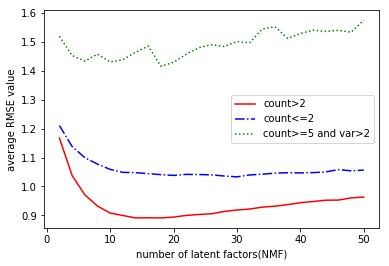

In [62]:
l1, = plt.plot(k_nnmf, rmse_pop_nnmf, 'r-', label='count>2')
l2, = plt.plot(k_nnmf, rmse_unpop_nnmf, 'b-.', label='count<=2')
l3, = plt.plot(k_nnmf, rmse_highvar_nnmf, 'g:', label='count>=5 and var>2')
plt.xlabel('number of latent factors(NMF)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l1, l2, l3])
plt.show()

In [63]:
i_p = np.argsort(rmse_pop_nnmf)[0]
i_up = np.argsort(rmse_unpop_nnmf)[0]
i_hv = np.argsort(rmse_highvar_nnmf)[0]
print ('k that gives the minimum average RMSE for (popular, unpopular, \
high variance): \n(%d, %d, %d)\n' % (k_nnmf[i_p], k_nnmf[i_up], k_nnmf[i_hv]))

print ('minimum average RMSE for (popular, unpopular, \
high variance): \n(%.4f, %.4f, %.4f)\n' % (rmse_pop_nnmf[i_p], \
                                          rmse_unpop_nnmf[i_up], \
                                           rmse_highvar_nnmf[i_hv]))

k that gives the minimum average RMSE for (popular, unpopular, high variance): 
(14, 30, 18)

minimum average RMSE for (popular, unpopular, high variance): 
(0.8911, 1.0331, 1.4156)



#### Question 22

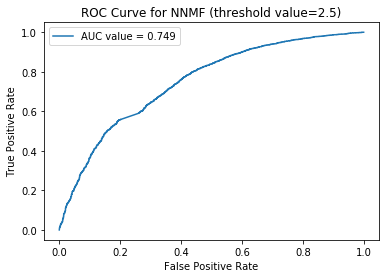

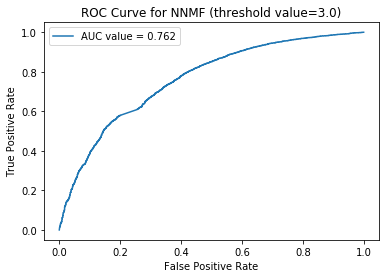

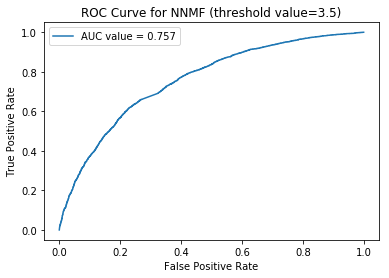

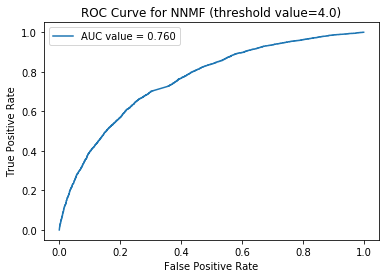

In [121]:
from sklearn import metrics
from surprise.model_selection import train_test_split
# use optimal number of latent factors that minimize RMSE
opt_lfactor_nmf = 16
thresholdlist = [2.5, 3, 3.5, 4]

pred = None
if GET_DATA_FROM_FILES and os.path.isfile("./pred_q22.pkl"):
    logging.info("Loading pred_q22.")
    pred = pickle.load(open("./pred_q22.pkl", "rb"))
else:
    algo = NMF(n_factors=opt_lfactor_nmf)
    trainset, testset = train_test_split(data, test_size=.1)
    algo.fit(trainset)
    pred = algo.test(testset)
    pickle.dump(pred, open("./pred_q22.pkl", "wb"))
        
for ths in thresholdlist:
    y_true=[]
    y_pred=[]
    for _,_,r_real,r_pred,_ in pred:
        if r_real >= ths:
            y_true.append(1)
        else:
            y_true.append(0)
        y_pred.append(r_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, label='AUC value = %0.3f' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for NNMF (threshold value=%.1f)' % ths)
    plt.legend()
    plt.show()

#### Question 23

In [65]:
m_data = pd.read_csv('data/movies.csv', header=0, usecols=[0, 1, 2])
print(m_data.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [66]:
k_q23=20
algo = NMF(n_factors=k_q23)
trainset = data.build_full_trainset()
algo.fit(trainset)

for c in range(10):
    col_top10 = np.argsort(-algo.qi[:,c])[:10]
    gcol = [m_data['genres'][i] for i in col_top10]
    print(gcol)
    print('-'*70)
    

['Comedy|Drama|Romance', 'Comedy', 'Drama', 'Drama', 'Comedy|Horror', 'Adventure|Animation|Children|Comedy|Musical', 'Comedy|Romance', 'Drama', 'Drama', 'Adventure|Comedy|Fantasy|Sci-Fi']
----------------------------------------------------------------------
['Comedy|Romance', 'Animation|Comedy|War', 'Drama', 'Comedy|Drama', 'Drama', 'Drama', 'Adventure|Drama|Romance', 'Drama', 'Drama', 'Drama|Romance']
----------------------------------------------------------------------
['Drama|Horror|Thriller', 'Drama|Mystery|Thriller', 'Drama', 'Crime|Drama', 'Adventure|Sci-Fi|Thriller', 'Comedy', 'Comedy', 'Comedy|Drama', 'Comedy|Drama', 'Comedy|Drama|Romance']
----------------------------------------------------------------------
['Horror|Sci-Fi|Thriller', 'Sci-Fi|Thriller', 'Mystery|Thriller', 'Drama|Thriller', 'Adventure|Comedy|Sci-Fi', 'Musical', 'Comedy', 'Action|Adventure|Drama|Sci-Fi', 'Comedy|Drama', 'Adventure|Comedy|Mystery|Romance']
-----------------------------------------------------

#### Question 24

In [67]:
from surprise import SVD
k_svd = range(2,51,2)

rmse_svd=[]
mae_svd=[]

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_svd.pkl")\
                    and os.path.isfile("./mae_svd.pkl"):
    logging.info("Loading rmse_svd and mae_svd.")
    rmse_svd = pickle.load(open("./rmse_svd.pkl", "rb"))
    mae_svd = pickle.load(open("./mae_svd.pkl", "rb"))
else:
    for k in k_svd:
        algo = SVD(n_factors=k, biased=True)
        result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10)
        rmse_svd.append(np.mean(result['test_rmse']))
        mae_svd.append(np.mean(result['test_mae']))
    
    pickle.dump(rmse_svd, open("./rmse_svd.pkl", "wb"))    
    pickle.dump(mae_svd, open("./mae_svd.pkl", "wb"))

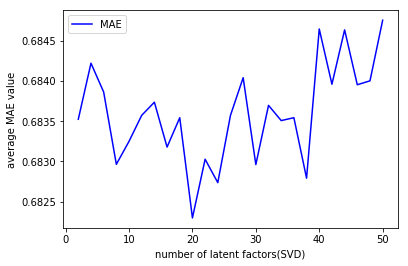

In [68]:
l1, = plt.plot(k_svd, mae_svd, 'b-', label='MAE')
plt.xlabel('number of latent factors(SVD)')
plt.ylabel('average MAE value')
plt.legend(handles=[l1])
plt.show()

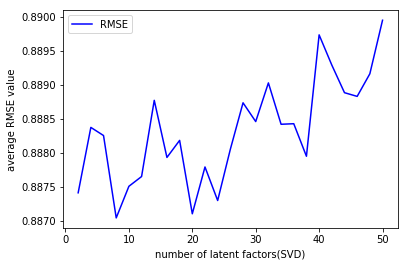

In [69]:
l2, = plt.plot(k_svd, rmse_svd, 'b-', label='RMSE')
plt.xlabel('number of latent factors(SVD)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l2])
plt.show()

#### Question 25

In [70]:
i = np.argsort(rmse_svd)[0]
print('the value of k that gives the minimum average RMSE')
print(k_svd[i])
print('minimum average RMSE:')
print(rmse_svd[i])

the value of k that gives the minimum average RMSE
8
minimum average RMSE:
0.887038486842


In [71]:
i = np.argsort(mae_svd)[0]
print('the value of k that gives the minimum average MAE')
print(k_svd[i])
print('minimum average MAE:')
print(mae_svd[i])

the value of k that gives the minimum average MAE
20
minimum average MAE:
0.682298752979


#### Question 26,27,28

In [72]:
rmse_pop_svd = []
rmse_unpop_svd = []
rmse_highvar_svd = []

if GET_DATA_FROM_FILES and os.path.isfile("./rmse_pop_svd.pkl")\
                    and os.path.isfile("./rmse_unpop_svd.pkl")\
                    and os.path.isfile("./rmse_highvar_svd.pkl"):
    logging.info("Loading rmse_pop_svd, rmse_unpop_svd and rmse_highvar_svd.")
    rmse_pop_svd = pickle.load(open("./rmse_pop_svd.pkl", "rb"))
    rmse_unpop_svd = pickle.load(open("./rmse_unpop_svd.pkl", "rb"))
    rmse_highvar_svd = pickle.load(open("./rmse_highvar_svd.pkl", "rb"))
else:
    for k in k_svd:
        rmse_temp_pop_svd = []
        rmse_temp_unpop_svd = []
        rmse_temp_highvar_svd = []
        algo = SVD(n_factors=k, biased=True)
        for trainset,testset in kf.split(data):
            algo.fit(trainset)
            predictions_pop_svd = algo.test(trim_popular(testset))
            predictions_unpop_svd = algo.test(trim_unpopular(testset))
            predictions_highvar_svd = algo.test(trim_highvar(testset))
            rmse_temp_pop_svd.append(accuracy.rmse(predictions_pop_svd))
            rmse_temp_unpop_svd.append(accuracy.rmse(predictions_unpop_svd))
            rmse_temp_highvar_svd.append(accuracy.rmse(predictions_highvar_svd))
        rmse_pop_svd.append(np.mean(rmse_temp_pop_svd))
        rmse_unpop_svd.append(np.mean(rmse_temp_unpop_svd))
        rmse_highvar_svd.append(np.mean(rmse_temp_highvar_svd))

    pickle.dump(rmse_pop_svd, open("./rmse_pop_svd.pkl", "wb"))    
    pickle.dump(rmse_unpop_svd, open("./rmse_unpop_svd.pkl", "wb"))
    pickle.dump(rmse_highvar_svd, open("./rmse_highvar_svd.pkl", "wb"))

print(rmse_pop_svd[:5])

[0.86489182034745793, 0.86640780476399881, 0.86658046334978012, 0.86553412597164725, 0.86681589951789384]


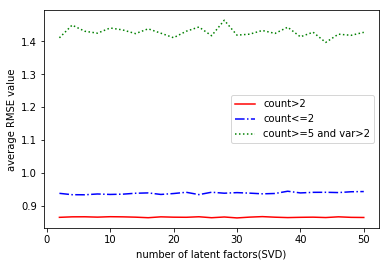

In [73]:
l1, = plt.plot(k_svd, rmse_pop_svd, 'r-', label='count>2')
l2, = plt.plot(k_svd, rmse_unpop_svd, 'b-.', label='count<=2')
l3, = plt.plot(k_svd, rmse_highvar_svd, 'g:', label='count>=5 and var>2')
plt.xlabel('number of latent factors(SVD)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l1, l2, l3])
plt.show()

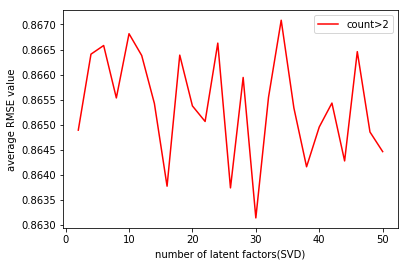

In [74]:
l1, = plt.plot(k_svd, rmse_pop_svd, 'r-', label='count>2')
plt.xlabel('number of latent factors(SVD)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l1])
plt.show()

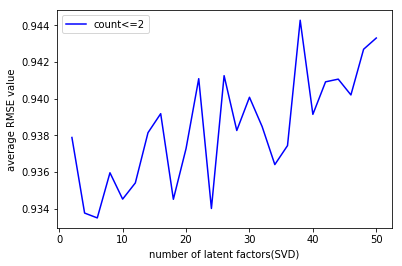

In [75]:
l2, = plt.plot(k_svd, rmse_unpop_svd, 'b-', label='count<=2')
plt.xlabel('number of latent factors(SVD)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l2])
plt.show()

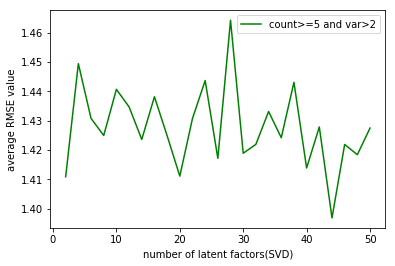

In [76]:
l3, = plt.plot(k_svd, rmse_highvar_svd, 'g-', label='count>=5 and var>2')
plt.xlabel('number of latent factors(SVD)')
plt.ylabel('average RMSE value')
plt.legend(handles=[l3])
plt.show()

In [77]:
i_p = np.argsort(rmse_pop_svd)[0]
i_up = np.argsort(rmse_unpop_svd)[0]
i_hv = np.argsort(rmse_highvar_svd)[0]
print ('k that gives the minimum average RMSE for (popular, unpopular, \
high variance): \n(%d, %d, %d)\n' % (k_svd[i_p], k_svd[i_up], k_svd[i_hv]))

print ('minimum average RMSE for (popular, unpopular, \
high variance): \n(%.4f, %.4f, %.4f)\n' % (rmse_pop_svd[i_p], \
                                          rmse_unpop_svd[i_up], \
                                           rmse_highvar_svd[i_hv]))

k that gives the minimum average RMSE for (popular, unpopular, high variance): 
(30, 6, 44)

minimum average RMSE for (popular, unpopular, high variance): 
(0.8631, 0.9335, 1.3969)



#### Question 29

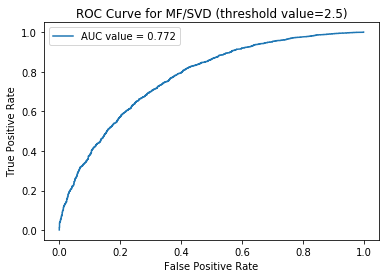

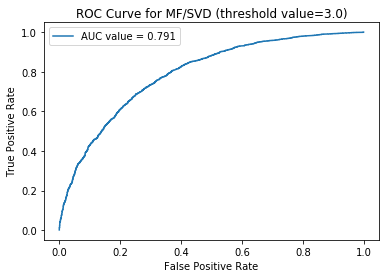

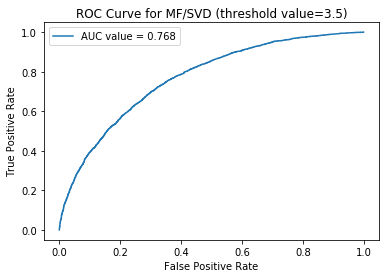

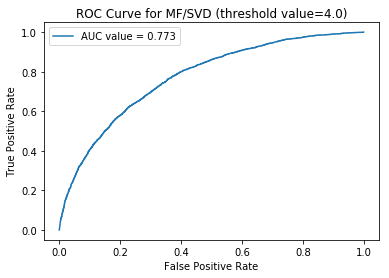

In [123]:
opt_lfactor_svd = 18

pred = None
if GET_DATA_FROM_FILES and os.path.isfile("./pred_q29.pkl"):
    logging.info("Loading pred_q29.")
    pred = pickle.load(open("./pred_q29.pkl", "rb"))
else:
    algo = SVD(n_factors=opt_lfactor_svd, biased=True)
    trainset, testset = train_test_split(data, test_size=.1)
    algo.fit(trainset)
    pred = algo.test(testset)
    pickle.dump(pred, open("./pred_q29.pkl", "wb"))
        
for ths in thresholdlist:
    y_true=[]
    y_pred=[]
    for _,_,r_real,r_pred,_ in pred:
        if r_real >= ths:
            y_true.append(1)
        else:
            y_true.append(0)
        y_pred.append(r_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    plt.plot(fpr, tpr, label='AUC value = %0.3f' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for MF/SVD (threshold value=%.1f)' % ths)
    plt.legend()
    plt.show()

#### Question 30

In [79]:
from surprise import AlgoBase

class Naive(AlgoBase):

    def __init__(self):

        # Always call base method before doing anything.
        AlgoBase.__init__(self)
        
    def fit(self, trainset):

        # Here again: call base method before doing anything.
        AlgoBase.fit(self, trainset)
        self.udict = dict()
        
        try:
            for uid in self.trainset.all_users():
                self.udict[uid] = np.mean([r for (_, r) in
                                 self.trainset.ur[uid]])
        except StopIteration:
            pass


    def estimate(self, u, i):
        if u in self.udict:
            return self.udict[u]
        else:
            return trainset.global_mean


algo = Naive()
algo.fit(trainset)

result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, n_jobs=1)

In [80]:
print (np.mean(result['test_rmse']))
print (np.mean(result['test_mae']))

0.962137823277
0.749825023377


#### Question 31,32,33

In [103]:
kf = KFold(n_splits=10)

rmse_temp_pop_naive = []
rmse_temp_unpop_naive = []
rmse_temp_highvar_naive = []
algo = Naive()
for trainset,testset in kf.split(data):
    algo.fit(trainset)
    predictions_pop_naive = algo.test(trim_popular(testset))
    predictions_unpop_naive = algo.test(trim_unpopular(testset))
    predictions_highvar_naive = algo.test(trim_highvar(testset))
    rmse_temp_pop_naive.append(accuracy.rmse(predictions_pop_naive, verbose=False))
    rmse_temp_unpop_naive.append(accuracy.rmse(predictions_unpop_naive, verbose=False))
    rmse_temp_highvar_naive.append(accuracy.rmse(predictions_highvar_naive, verbose=False))

In [104]:
print('average RMSE for (popular, unpopular, \
high variance): \n(%.4f, %.4f, %.4f)\n' % (np.mean(rmse_temp_pop_naive), \
                                          np.mean(rmse_temp_unpop_naive), \
                                           np.mean(rmse_temp_highvar_naive)))

average RMSE for (popular, unpopular, high variance): 
(0.9483, 0.9944, 1.4508)



#### Question 34

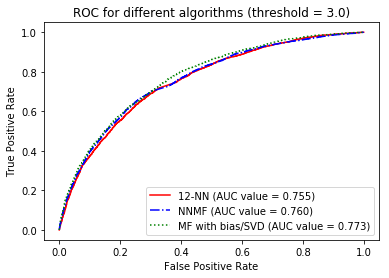

In [113]:
pred_svd = None
if GET_DATA_FROM_FILES and os.path.isfile("./pred_q29.pkl"):
    logging.info("Loading pred_q29.")
    pred_svd = pickle.load(open("./pred_q29.pkl", "rb"))
else:
    algo = SVD(n_factors=opt_lfactor_svd, biased=True)
    trainset, testset = train_test_split(data, test_size=.1)
    algo.fit(trainset)
    pred_svd = algo.test(testset)
    pickle.dump(pred_svd, open("./pred_q29.pkl", "wb"))
    
pred_nmf = None
if GET_DATA_FROM_FILES and os.path.isfile("./pred_q22.pkl"):
    logging.info("Loading pred_q22.")
    pred_nmf = pickle.load(open("./pred_q22.pkl", "rb"))
else:
    algo = NMF(n_factors=opt_lfactor_nmf)
    trainset, testset = train_test_split(data, test_size=.1)
    algo.fit(trainset)
    pred_nmf = algo.test(testset)
    pickle.dump(pred_nmf, open("./pred_q22.pkl", "wb"))
    
pred_knn = None
if GET_DATA_FROM_FILES and os.path.isfile("./pred_q15.pkl"):
    logging.info("Loading pred_q15.")
    pred_knn = pickle.load(open("./pred_q15.pkl", "rb"))
else:
    algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=mink, sim_options=sim_options)
    trainset, testset = train_test_split(data, test_size=.1)
    algo.fit(trainset)
    pred_knn = algo.test(testset)
    pickle.dump(pred_knn, open("./pred_q15.pkl", "wb"))

thres_q34 = 3.0
pred_list = [pred_knn, pred_nmf, pred_svd]
pred_list_name = ['%d-NN' % mink,
                  'NNMF',
                 'MF with bias/SVD']
pred_line = []
pred_line_opt = ['r-', 'b-.', 'g:']
for idx, pred in enumerate(pred_list):
    y_true=[]
    y_pred=[]
    for _,_,r_real,r_pred,_ in pred:
        if r_real >= ths:
            y_true.append(1)
        else:
            y_true.append(0)
        y_pred.append(r_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred, pos_label=1)
    label = pred_list_name[idx] + ' (AUC value = %0.3f)' % metrics.roc_auc_score(y_true=y_true, y_score=y_pred)
    l, = plt.plot(fpr, tpr, pred_line_opt[idx], label=label)
    pred_line.append(l)

                  
plt.legend(handles=pred_line)
plt.title('ROC for different algorithms (threshold = %.1f)' % thres_q34)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
    


#### Question 35

*TODO*

#### Question 36

In [140]:
from collections import defaultdict

def precision_n_recall(predictions, th=3.0, t=1, verbose=True):

    if not predictions:
        raise ValueError('Prediction list is empty.')

    user_true_est = defaultdict(list)
    for uid, _, r_ui, est, _ in predictions:
        user_true_est[uid].append((r_ui, est))
    
    precision_lst = []
    recall_lst = []
    for uid, true_est in user_true_est.items():
        true_est.sort(key=lambda x: x[1], reverse=True)
        recommend_set = true_est[:t]
        rec = sum((est > th) for (_, est) in recommend_set)
        like = sum((r_ui > th) for (r_ui, _) in recommend_set)
        rec_n_like = sum((r_ui > th) and (est > th)\
                                      for (r_ui, est) in recommend_set)
        if (rec!=0):
            precision_lst.append(rec_n_like*1.0/rec)
        if (like!=0):
            recall_lst.append(rec_n_like*1.0/like)
    
    precision = np.mean(precision_lst)
    recall = np.mean(recall_lst)
    if verbose:
        print('Precision: {0:1.3f}'.format(precision))
        print('Recall: {0:1.3f}'.format(recall))
    return precision, recall

In [145]:
t_lst = range(1,26,1)

knn_precis = defaultdict(list)
knn_recall = defaultdict(list)
thres = 3.0

algo = surprise.prediction_algorithms.knns.KNNWithMeans(k=mink, sim_options=sim_options)

for trainset,testset in kf.split(data):
    algo.fit(trainset)
    pred = algo.test(testset) 
    for t in t_lst:
        p, r = precision_n_recall(pred, t=t, th = thres, verbose=False)
        knn_precis[t].append(p)
        knn_recall[t].append(r)
        
ave_precis_knn = [np.mean(ls) for _, ls in knn_precis.items()]
ave_recall_knn = [np.mean(ls) for _, ls in knn_recall.items()]
    

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


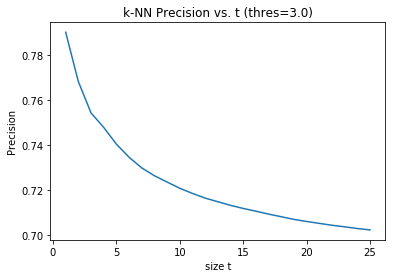

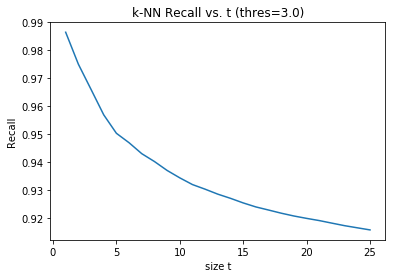

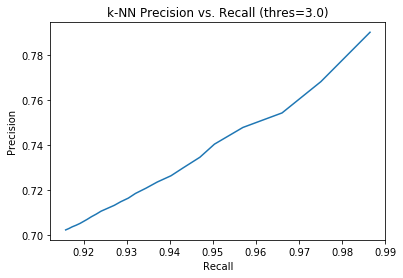

In [146]:
plt.figure()
plt.title("k-NN Precision vs. t (thres=%.1f)" % thres)
plt.ylabel("Precision")
plt.xlabel("size t")
plt.plot(t_lst, ave_precis_knn)
plt.show()

plt.figure()
plt.title("k-NN Recall vs. t (thres=%.1f)" % thres)
plt.ylabel("Recall")
plt.xlabel("size t")
plt.plot(t_lst, ave_recall_knn)
plt.show()

plt.figure()
plt.title("k-NN Precision vs. Recall (thres=%.1f)" % thres)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.plot(ave_recall_knn, ave_precis_knn)
plt.show()

#### Question 37

In [147]:
nmf_precis = defaultdict(list)
nmf_recall = defaultdict(list)
thres = 3.0

algo = NMF(n_factors=k_q23)

for trainset,testset in kf.split(data):
    algo.fit(trainset)
    pred = algo.test(testset) 
    for t in t_lst:
        p, r = precision_n_recall(pred, t=t, th = thres, verbose=False)
        nmf_precis[t].append(p)
        nmf_recall[t].append(r)
        
ave_precis_nmf = [np.mean(ls) for _, ls in nmf_precis.items()]
ave_recall_nmf = [np.mean(ls) for _, ls in nmf_recall.items()]
    

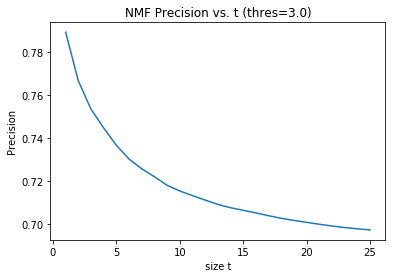

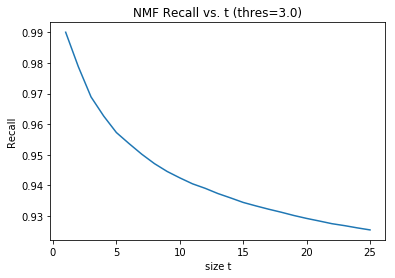

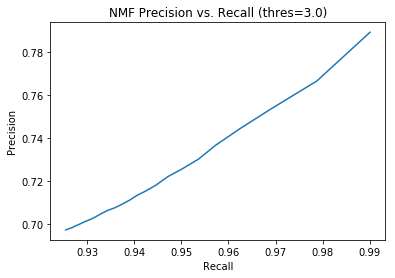

In [148]:
plt.figure()
plt.title("NMF Precision vs. t (thres=%.1f)" % thres)
plt.ylabel("Precision")
plt.xlabel("size t")
plt.plot(t_lst, ave_precis_nmf)
plt.show()

plt.figure()
plt.title("NMF Recall vs. t (thres=%.1f)" % thres)
plt.ylabel("Recall")
plt.xlabel("size t")
plt.plot(t_lst, ave_recall_nmf)
plt.show()

plt.figure()
plt.title("NMF Precision vs. Recall (thres=%.1f)" % thres)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.plot(ave_recall_nmf, ave_precis_nmf)
plt.show()

#### Question 38

In [149]:
svd_precis = defaultdict(list)
svd_recall = defaultdict(list)
thres = 3.0

algo = SVD(n_factors=opt_lfactor_svd, biased=True)

for trainset,testset in kf.split(data):
    algo.fit(trainset)
    pred = algo.test(testset) 
    for t in t_lst:
        p, r = precision_n_recall(pred, t=t, th = thres, verbose=False)
        svd_precis[t].append(p)
        svd_recall[t].append(r)
        
ave_precis_svd = [np.mean(ls) for _, ls in svd_precis.items()]
ave_recall_svd = [np.mean(ls) for _, ls in svd_recall.items()]
    

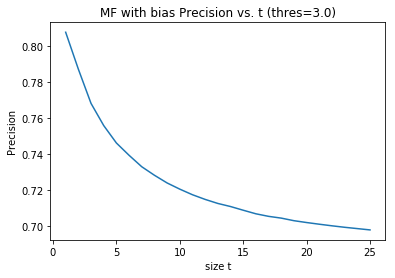

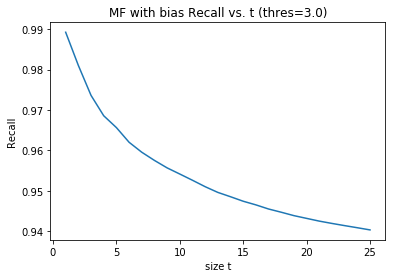

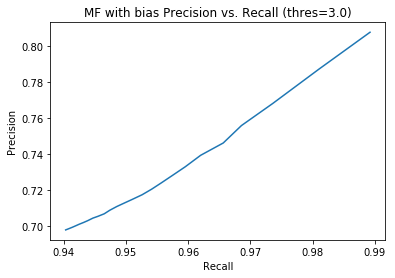

In [150]:
plt.figure()
plt.title("MF with bias Precision vs. t (thres=%.1f)" % thres)
plt.ylabel("Precision")
plt.xlabel("size t")
plt.plot(t_lst, ave_precis_svd)
plt.show()

plt.figure()
plt.title("MF with bias Recall vs. t (thres=%.1f)" % thres)
plt.ylabel("Recall")
plt.xlabel("size t")
plt.plot(t_lst, ave_recall_svd)
plt.show()

plt.figure()
plt.title("MF with bias Precision vs. Recall (thres=%.1f)" % thres)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.plot(ave_recall_svd, ave_precis_svd)
plt.show()

#### Question 39

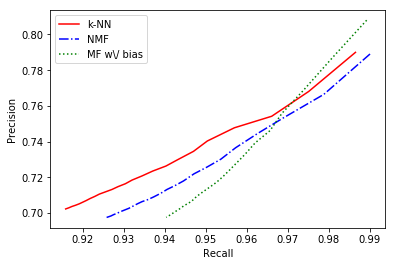

In [151]:
l1, = plt.plot(ave_recall_knn, ave_precis_knn, 'r-', label='k-NN')
l2, = plt.plot(ave_recall_nmf, ave_precis_nmf, 'b-.', label='NMF')
l3, = plt.plot(ave_recall_svd, ave_precis_svd, 'g:', label='MF w\/ bias')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(handles=[l1, l2, l3])
plt.show()